In [1]:
import chess, chess.polyglot, chess.engine, chess.pgn
from chess import Move, PieceType, Square
from typing import Optional, Callable, Iterator
import random
import math
from IPython.display import display, clear_output

In [2]:
class TranspositionTableEntry:
    def __init__(self, depth, value, flag):
        self.depth = depth
        self.value = value
        self.flag = flag
        
class TranspositionTable:
    def __init__(self):
        self.table = {}
        self.n_pos = 0

    def add(self, hashcode: int, tt_entry: TranspositionTableEntry):
        self.table[str(hashcode)] = tt_entry

    def get(self, hashcode: int) -> TranspositionTableEntry:
        try:
            return self.table[str(hashcode)]
        except:
            return None

In [256]:
def ai_move(board: chess.Board, depth, tt: TranspositionTable = None) -> chess.Move:
    best_v = -math.inf
    best_move = None

    moves = ordered_moves(board)

    for move in moves:
        board.push(move)
        v = -negamax(board, depth, -math.inf, math.inf, tt)
        board.pop()
        
        print(move, v)

        # if game ending move was found
        if v == math.inf:
            best_move = move
            return best_move

        if v > best_v:
            best_v = v
            best_move = move

    if best_move == None:
        return random.choice(moves)

    return best_move

def negamax(board: chess.Board, depth: int, alpha: float, beta: float, 
            tt: TranspositionTable = None) -> float:
    if tt is not None:
        hashcode = hash(board._transposition_key())
        alpha_org = alpha
        tt_entry = tt.get(hashcode)
        if tt_entry is not None and tt_entry.depth >= depth:
            if tt_entry.flag == "EXACT":
                return tt_entry.value
            elif tt_entry.flag == "LOWERBOUND":
                alpha = max(alpha, tt_entry.value)
            elif tt_entry.flag == "UPPERBOUND":
                beta = min(beta, tt_entry.value)
            if alpha >= beta:
                return tt_entry.value

    if depth == 0 or board.is_game_over():
        if tt is not None:
            tt.n_pos += 1
        return negamax_captures(board, alpha, beta)
        return calc_eval(board) if board.turn else -calc_eval(board)
    
    v = -math.inf
    for move in ordered_moves(board):
        board.push(move)
        v = max(v, -negamax(board, depth-1, -beta, -alpha, tt))
        board.pop()

        alpha = max(alpha, v)
        if alpha >= beta:
            break
    
    if tt is not None:
        flag = "EXACT"
        tt_entry = TranspositionTableEntry(depth, v, flag)
        tt_entry.value = v
        if v <= alpha_org:
            flag = "UPPERBOUND"
        elif v >= beta:
            flag = "LOWERBOUND"
        tt_entry.flag = flag
        tt.add(hashcode, tt_entry)

    return v
    
def negamax_captures(board: chess.Board, alpha: float, beta: float) -> float:
    v = calc_eval(board) if board.turn else -calc_eval(board)
    if v > beta:
        return beta

    alpha = max(alpha, v)
    
    for move in ordered_moves(board, only_captures=True):
        board.push(move)
        v = -negamax_captures(board, -beta, -alpha)
        board.pop()

        if v >= beta:
            return beta
        alpha = max(alpha, v)

    return alpha

def calc_eval(board: chess.Board):
    if board.is_game_over():
        if board.result() == "1-0":
            return math.inf
        elif board.result() == "0-1":
            return -math.inf
        else:
            return 0
            
    v = 0
    for s in chess.scan_reversed(board.occupied & chess.BB_ALL):
        row = s // 8
        col = s % 8

        piece = board.piece_at(s)
        v += piece_value(piece)
        v += psqt_bonus(row, col, piece)
        v += 69 * hanging(board, s, piece)

    return v

def hanging(board: chess.Board, sqr: chess.Square, piece: chess.Piece = None):
    w_attackers = board.attackers(chess.WHITE, sqr)
    b_attackers = board.attackers(chess.BLACK, sqr)

    if piece is None:
        piece = board.piece_at(sqr)

    v = 0
    # check white hanging (better for black)
    if len(w_attackers) == 0 and len(b_attackers) > 0 and piece.color:
        v -= 1
        
    # check black hanging (better for white)
    if len(b_attackers) == 0 and len(w_attackers) > 0 and not piece.color:
        v += 1

    return v

def piece_value(piece: chess.Piece, mg: bool = True):
    """
    returns value of a piece.
    """
    piece_values = [124, 781, 825, 1276, 2538, 0] if mg else [206, 854, 915, 1380, 2682, 0]
    return piece_values[piece.piece_type - 1] if piece.color else -piece_values[piece.piece_type - 1]

def psqt_bonus(row: int, col: int, piece: chess.Piece, mg: bool = True):
        """
        row: row # in bitboard (starts from top-left)
        col: col # in bitboard (starts from top-left)
        piece_idx: one char in 'PNBRQKpnbrqk'
        mg: is it middle game?
        """
        piece_idx = piece.piece_type - 1 # -1 because it chess.PIECE_TYPES starts from 1
        bonus = [
        [[-175,-92,-74,-73],[-77,-41,-27,-15],[-61,-17,6,12],[-35,8,40,49],[-34,13,44,51],[-9,22,58,53],[-67,-27,4,37],[-201,-83,-56,-26]],
        [[-53,-5,-8,-23],[-15,8,19,4],[-7,21,-5,17],[-5,11,25,39],[-12,29,22,31],[-16,6,1,11],[-17,-14,5,0],[-48,1,-14,-23]],
        [[-31,-20,-14,-5],[-21,-13,-8,6],[-25,-11,-1,3],[-13,-5,-4,-6],[-27,-15,-4,3],[-22,-2,6,12],[-2,12,16,18],[-17,-19,-1,9]],
        [[3,-5,-5,4],[-3,5,8,12],[-3,6,13,7],[4,5,9,8],[0,14,12,5],[-4,10,6,8],[-5,6,10,8],[-2,-2,1,-2]],
        [[271,327,271,198],[278,303,234,179],[195,258,169,120],[164,190,138,98],[154,179,105,70],[123,145,81,31],[88,120,65,33],[59,89,45,-1]]
        ] if mg else [
        [[-96,-65,-49,-21],[-67,-54,-18,8],[-40,-27,-8,29],[-35,-2,13,28],[-45,-16,9,39],[-51,-44,-16,17],[-69,-50,-51,12],[-100,-88,-56,-17]],
        [[-57,-30,-37,-12],[-37,-13,-17,1],[-16,-1,-2,10],[-20,-6,0,17],[-17,-1,-14,15],[-30,6,4,6],[-31,-20,-1,1],[-46,-42,-37,-24]],
        [[-9,-13,-10,-9],[-12,-9,-1,-2],[6,-8,-2,-6],[-6,1,-9,7],[-5,8,7,-6],[6,1,-7,10],[4,5,20,-5],[18,0,19,13]],
        [[-69,-57,-47,-26],[-55,-31,-22,-4],[-39,-18,-9,3],[-23,-3,13,24],[-29,-6,9,21],[-38,-18,-12,1],[-50,-27,-24,-8],[-75,-52,-43,-36]],
        [[1,45,85,76],[53,100,133,135],[88,130,169,175],[103,156,172,172],[96,166,199,199],[92,172,184,191],[47,121,116,131],[11,59,73,78]]
        ]

        pbonus = [[0,0,0,0,0,0,0,0],[3,3,10,19,16,19,7,-5],[-9,-15,11,15,32,22,5,-22],[-4,-23,6,20,40,17,4,-8],
        [13,0,-13,1,11,-2,-13,5],[5,-12,-7,22,-8,-5,-15,-8],[-7,7,-3,-13,5,-16,10,-8],[0,0,0,0,0,0,0,0]
        ] if mg else[
        [0,0,0,0,0,0,0,0],[-10,-6,10,0,14,7,-5,-19],[-10,-10,-10,4,4,3,-6,-4],[6,-2,-8,-4,-13,-12,-10,-9],[10,5,4,-5,-5,-5,14,9],
        [28,20,21,28,30,7,6,13],[0,-11,12,21,25,19,4,7],[0,0,0,0,0,0,0,0]]

        if piece_idx == 0:
            row = (7 - row) if piece.color else row # 7 - row, filps board row wise 
            v = pbonus[row][col]
        elif piece_idx > 0:
            row = (7 - row) if piece.color else row
            col = min(col, 7 - col) # this code mirrors left half of board
            v = bonus[piece_idx-1][row][col]
        else:
            v = 0

        v = v / 10 # reducing the factor because the maximum is near 199

        return v if piece.color else -v

def ordered_moves(board: chess.Board, only_captures=False):

    def move_score(m: chess.Move):
        score = 0
        move_piece = board.piece_at(m.from_square)
        capture_piece = board.piece_at(m.to_square)

        if capture_piece is not None:
            # motivate lower pieces to capture higher piece
            score += abs(piece_value(capture_piece)) - abs(piece_value(move_piece))
        else:
            # demotivates squares with more attackers and less defenders (no hanging!)
            attackers = board.attackers(not move_piece.color, m.to_square)
            defenders = board.attackers(move_piece.color, m.to_square)
            if m.from_square in defenders:
                defenders.remove(m.from_square)

            score += len(defenders) - len(attackers)

        return score
    if only_captures:
        return sorted(board.generate_legal_captures(), key=move_score, reverse=True)
    return sorted(board.generate_legal_moves(), key=move_score, reverse=True)

In [265]:
board = chess.Board()
tt = TranspositionTable()

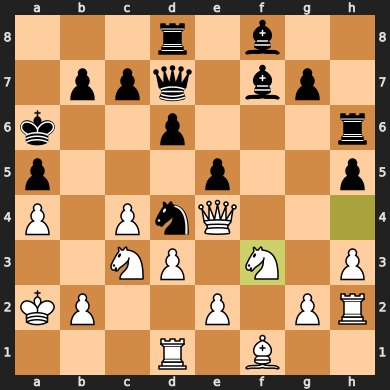

In [280]:
board

In [281]:
ordered_moves(board, only_captures=True)

[Move.from_uci('d4f3'),
 Move.from_uci('d4e2'),
 Move.from_uci('f7c4'),
 Move.from_uci('d7a4'),
 Move.from_uci('d7h3')]

In [262]:
best_move = ai_move(board, 2)
best_move

f3f4 -49.99999999999818
c2c3 -117.10000000000059
c2c4 -53.19999999999982
d5f4 -50.79999999999745
d5c3 0.2999999999985903
g3f4 -118.00000000000159
e3c4 -785.3999999999994
e3d1 -715.8999999999994
h2h3 -52.29999999999927
d2d1 -51.19999999999955
e3g4 -785.3999999999994
h2h1 -51.7999999999995
f2g1 -51.49999999999932
f2e1 -51.49999999999937
b1a2 -781.4999999999983
b1c1 -54.69999999999927
b1a1 -53.29999999999927
b2b3 0.2999999999989087
d5b6 -786.8999999999996
e3f5 -786.9999999999998
d3d4 -127.60000000000008
b2b4 -190.49999999999932
d5b4 -784.1999999999989
g3e5 -826.3
d5e7 -664.6999999999989
d5c7 -663.8999999999996
d5f6 -663.8999999999996
g3d6 -701.0000000000007


Move.from_uci('b2b3')

In [38]:
board.push(best_move)

In [41]:
list(board.move_stack)

[Move.from_uci('d5f4')]

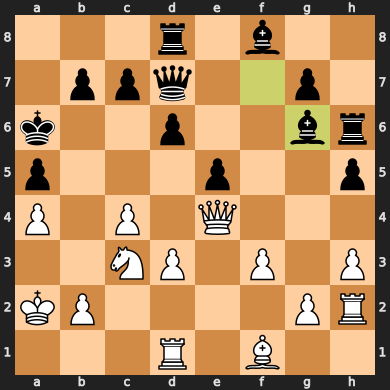

-44.500000000001 7287
e4d5 -45.100000000001366
e4e2 -40.70000000000082
c3d5 -2595.9
c3e2 -2713.2000000000003
c3b1 -2717.8999999999996
a2b1 -1755.7000000000003
f1e2 -1754.4
d1b1 -1758.6000000000004
e4e1 -41.70000000000105
a2a3 -2449.500000000001
a2a1 -1758.7000000000003
d1e1 -1755.8000000000002
d1a1 -1758.4000000000003
h3h4 -1754.5
b2b3 -1757.6999999999998
g2g4 -1760.8000000000002
e4h4 -45.40000000000064
e4g4 -2459.300000000001
e4e3 -40.100000000000456
c3b5 -1760.8000000000002
h2h1 -1757.3000000000002
a2b3 -1750.1000000000004
d1d2 -1754.9
d1c1 -1756.8000000000002
f3f4 -1882.5999999999995
d3d4 -1757.8999999999996
g2g3 -1758.3000000000002
e4f4 -2577.9000000000005
e4d4 -2519.9000000000005


KeyboardInterrupt: 

In [266]:
while not board.is_game_over():
    best_move = ai_move(board, 2, tt)
    board.push(best_move)
    clear_output(wait=True)
    display(board)
    print(calc_eval(board), tt.n_pos)
    tt.n_pos = 0

In [171]:
str(chess.pgn.Game.from_board(board))

'[Event "?"]\n[Site "?"]\n[Date "????.??.??"]\n[Round "?"]\n[White "?"]\n[Black "?"]\n[Result "1/2-1/2"]\n\n1. Nf3 Nf6 2. Ne5 Ne4 3. d3 Nd6 4. Nc3 f6 5. Ng4 Nc6 6. Bf4 e5 7. Bg3 Nf5 8. Ne3 Nxe3 9. fxe3 Bb4 10. Kd2 O-O 11. a4 d6 12. e4 Be6 13. Qb1 a5 14. h4 Rf7 15. Rh2 Rc8 16. Kc1 f5 17. Na2 f4 18. Nxb4 fxg3 19. Nxc6 Rxf1+ 20. Kd2 Rxb1 21. Nxd8 gxh2 22. Rxb1 Bd7 23. Nxb7 Rb8 24. Nxa5 Ra8 25. Nc4 Rxa4 26. Rh1 Bc6 27. Rxh2 Rb4 28. Kc3 Rb7 29. Na5 Rb6 30. Nxc6 Rxc6+ 31. Kb3 Rb6+ 32. Ka2 Rb4 33. Ka3 c5 34. Rh3 h5 35. Rg3 Kh7 36. c3 Rb7 37. Rg5 Kh6 38. Rf5 Ra7+ 39. Kb3 Rc7 40. Kc2 c4 41. dxc4 Rxc4 42. Kd3 Rc7 43. Rg5 Rf7 44. b4 Rf4 45. g3 Rf1 46. Kd2 Rf7 47. e3 Rf3 48. Ke2 Rf8 49. Kd3 Rc8 50. Kc2 Rc4 51. g4 hxg4 52. Rxg4 d5 53. Kd3 g6 54. Kc2 dxe4 55. Kb3 Kh5 56. Rg5+ Kxh4 57. Rxe5 Rc7 58. Rxe4+ Kg3 59. Re6 g5 60. Re5 g4 61. Re4 Kf3 62. Rf4+ Kxe3 63. Rxg4 Kf3 64. Rg6 Kf4 65. Re6 Kf5 66. Rd6 Ke5 67. Rh6 Ke4 68. Rh5 Ke3 69. Rf5 Rb7 70. c4 Ke4 71. Rh5 Kf3 72. Rg5 Kf4 73. Rd5 Re7 74. Rd4+ Kf3 75